In [1]:
#packages
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Dropout, Input, concatenate, Bidirectional, SimpleRNN,Flatten
from keras.optimizers import Adam
import tensorflow 
from keras import regularizers
from statsmodels.tsa.statespace.sarimax import SARIMAX


import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from scipy.stats import ttest_rel
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [2]:
#定义绘图函数：
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

#定义分箱函数：
#rolling分箱
def split_sequence(sequence,n_steps,n_forecast):
    a,b=list(),list()
    for i in range(len(sequence)):
        end_ix=i+n_steps
        end_ix_l=end_ix+n_forecast
        if end_ix_l>len(sequence):
            break
        seq_x,seq_y=sequence[i:end_ix],sequence[end_ix:end_ix_l]
        a.append(seq_x)
        b.append(seq_y)
        i=i+n_steps+n_forecast
    return np.array(a), np.array(b)


# define function to plot learning curve 学习曲线
def plot_learning_curve(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Learning Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


#测试每列预测值的偏差

def Var_output(preddata, truedata):
    list=[]
    for i in range(preddata.shape[1]):
        #print(i)
        diff=preddata[:,i]-truedata[:,i]
        var_i=np.var(diff)
        #print(i+diff)
        list.append(var_i)
    return list

def evaluate(y_true, y_pred, T):
    # 计算评估指标
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    # 返回评估指标和T检验结果
    return (f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, "
            f"MAPE: {mape:.4f}, R2: {r2:.4f}")



#美丽散点图
def plot_scatter(y_true, y_pred, labels=None, title=None):
    """
    Plot scatter plot of true vs predicted values.

    Args:
        y_true (numpy array): True values.
        y_pred (numpy array): Predicted values.
        labels (list): List of strings, labels for the predicted values.
        title (str): Title of the plot.

    Returns:
        None
    """
    n_features = y_true.shape[1]

    # Create figure and axis objects
    fig, ax = plt.subplots()

    # Scatter plot
    for i in range(n_features):
        color = 'C' + str(i)
        label = f'Forecast Day {i+1}'
        if labels:
            label = labels[i]
        ax.scatter(y_true[:, i], y_pred[:, i], color=color, label=label)

    # Add diagonal line
    lims = [np.min(y_true), np.max(y_true)]
    ax.plot(lims, lims, color='red', linestyle='--')

    # Set axis labels and title
    ax.set_xlabel('True values')
    ax.set_ylabel('Predicted values')
    if title:
        ax.set_title(title)

    ax.legend()

    # Show plot
    plt.show()



def plot_time_series(actual, predicted, xlabel='Time (days)', ylabel=None, title=None):
    """
    Plots the actual and predicted time series data.

    Parameters:
    actual (array-like): The actual time series data.
    predicted (array-like): The predicted time series data.
    xlabel (str): The label for the x-axis.
    ylabel (str): The label for the y-axis.
    title (str): The title of the plot.

    Returns:
    None
    """
    fig, ax = plt.subplots(figsize=(12,6))

    ax.plot(actual, label='Actual')
    ax.plot(predicted, color='red', label='Predicted')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    ax.legend()
    plt.show()



In [3]:
import os
import pandas as pd

# Get the script directory
script_dir = os.path.dirname(os.path.abspath(__file__))

# Change the working directory to the script's directory
os.chdir(script_dir)

# Exchange Rate
with open('JPYUSD.csv', 'r') as file:
    Er_JPUS_raw = pd.read_csv(file)
    Er_JPUS = Er_JPUS_raw.loc[:, ['TIME', 'Value']]
    Er_JPUS['TIME'] = pd.to_datetime(Er_JPUS['TIME'])

# Japan Producer Price Index
with open('PPI_JP.csv', 'r') as file:
    PPI_JP = pd.read_csv(file, header=None, nrows=519, skiprows=3)
    PPI_JP.iloc[:, 0] = PPI_JP.iloc[:, 0].str.replace('/', '-')
    PPI_JP.columns = ['TIME', 'Value']

# US Producer Price Index
with open('PPI_US.csv', 'r') as file:
    PPI_US = pd.read_csv(file)
    PPI_US.iloc[:, 0] = PPI_US.iloc[:, 0].str.slice(stop=7)
    PPI_US.columns = ['TIME', 'Value']

# Japan M1 Index
with open('M1_JP.csv', 'r') as file:
    M1_JP_raw = pd.read_csv(file)
    M1_JP = M1_JP_raw.loc[:, ['TIME', 'Value']]

# US M1 Index
with open('M1_US.csv', 'r') as file:
    M1_US_raw = pd.read_csv(file)
    M1_US = M1_US_raw.loc[:, ['TIME', 'Value']]

# Japan Industrial Production Index
with open('IPI_JP.csv', 'r') as file:
    IPI_JP = pd.read_csv(file)
    IPI_JP_SP = IPI_JP.loc[IPI_JP['Measure'] != 'Growth previous period', ['Measure', 'TIME', 'Value']]
    IPI_JP_PP = IPI_JP.loc[IPI_JP['Measure'] == 'Growth previous period', ['Measure', 'TIME', 'Value']]

# US Industrial Production Index
with open('IPI_US.csv', 'r') as file:
    IPI_US = pd.read_csv(file)
    IPI_US_SP = IPI_US.loc[IPI_US['Measure'] != 'Growth previous period', ['Measure', 'TIME', 'Value']]
    IPI_US_PP = IPI_US.loc[IPI_US['Measure'] == 'Growth previous period', ['Measure', 'TIME', 'Value']]

# Japan Bonds Yields
with open('IN_JP.csv', 'r') as file:
    IN_JP_raw = pd.read_csv(file)
    IN_JP_LT = IN_JP_raw.loc[IN_JP_raw['Subject'] == 'Long-term interest rates, Per cent per annum',
                            ['Subject', 'TIME', 'Value']]
    IN_JP_ST = IN_JP_raw.loc[IN_JP_raw['Subject'] == 'Short-term interest rates, Per cent per annum',
                            ['Subject', 'TIME', 'Value']]
    IN_JP_IM = IN_JP_raw.loc[IN_JP_raw['Subject'] == 'Immediate interest rates, Call Money, Interbank Rate, Per cent per annum',
                            ['Subject', 'TIME', 'Value']]

# US Bonds Yields
with open('IN_US.csv', 'r') as file:
    IN_US_raw = pd.read_csv(file)
    IN_US_LT = IN_US_raw.loc[IN_US_raw['Subject'] == 'Long-term interest rates, Per cent per annum',
                            ['Subject', 'TIME', 'Value']]
    IN_US_ST = IN_US_raw.loc[IN_US_raw['Subject'] == 'Short-term interest rates, Per cent per annum',
                            ['Subject', 'TIME', 'Value']]
    IN_US_IM = IN_US_raw.loc[IN_US_raw['Subject'] == 'Immediate interest rates, Call Money, Interbank Rate, Per cent per annum',
                            ['Subject', 'TIME', 'Value']]


In [4]:
data=Er_JPUS['Value'].values
data.shape

(520,)

/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test Mean Squared Error (smaller the better fit): 5.642


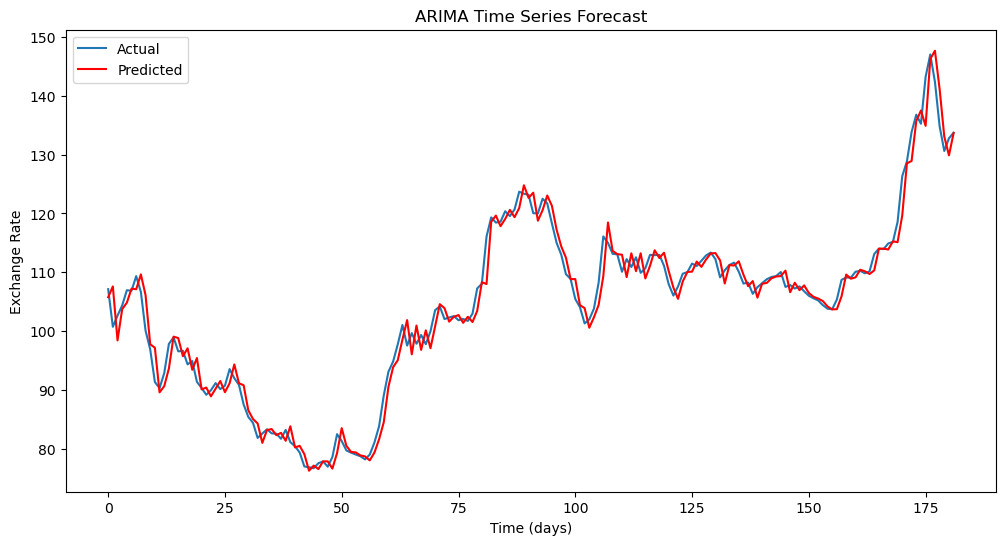

In [5]:
def StartARIMAForecasting(Actual, P, D, Q):
	model = SARIMAX(Actual, order=(P, D, Q), seasonal_order=(0, 0, 0, 0))
	model_fit = model.fit(disp=0)
	prediction = model_fit.forecast()[0]
	return prediction
#Size of exchange rates

NumberOfElements = len(data)

#Use 65% of data as training, rest 35% to Test model
TrainingSize = int(NumberOfElements * 0.65)
TrainingData = data[0:TrainingSize]
TestData = data[TrainingSize:NumberOfElements]

#new arrays to store actual and predictions
Actual = [x for x in TrainingData]
Predictions = list()


#in a for loop, predict values using ARIMA model
for timepoint in range(len(TestData)):
	ActualValue =  TestData[timepoint]
	#forcast value
	Prediction = StartARIMAForecasting(Actual, 2,1,2)    
	#print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
	#add it in the list
	Predictions.append(Prediction)
	Actual.append(ActualValue)


#Print MSE to see how good the model is
Error = mean_squared_error(TestData, Predictions)
print('Test Mean Squared Error (smaller the better fit): %.3f' % Error)

# Create plot with labels and legend
plt.figure(figsize=(12,6))
plt.plot(TestData, label='Actual')
plt.plot(Predictions, color='red', label='Predicted')
plt.title('ARIMA Time Series Forecast')
plt.xlabel('Time (days)')
plt.ylabel('Exchange Rate')
plt.legend()

plt.show()

In [6]:
# y_true为真实值，y_pred为预测值
mae = mean_absolute_error(TestData, Predictions)
mse = mean_squared_error(TestData, Predictions)
rmse = np.sqrt(mse)

pred_flat = Predictions
true_flat = TestData

mape = np.mean(np.abs((TestData - Predictions) / TestData)) * 100

r2 = r2_score(TestData, Predictions)

print('mae:'+str(mae),'mse:'+str(mse),'rmse:'+str(rmse), 'mape:', mape ,'r2:',r2)

mae:1.7530297637928456 mse:5.64217947493976 rmse:2.3753272353382724 mape: 1.6745586059666528 r2: 0.9740750734815354


In [7]:
'''一共生成n个residual value 用lstm预测residual value'''
# calculate residual part
residual_part = TestData - Predictions

In [8]:
n_month=10
n_forecast=1
residual_part2 = residual_part[:-2]#与IPI对齐
learn,predict=split_sequence(residual_part2,n_month,n_forecast)
print(learn.shape,predict.shape)

(170, 10) (170, 1)


In [9]:
'''取前80%数据用于训练,后20%用于测试'''

n=int(predict.shape[0]*0.8)
print('训练量:'+str(n)+' 测试量:'+str(predict.shape[0]-n))
train_x=learn[:n]
train_y=predict[:n]
test_x=learn[n:]
test_y=predict[n:]
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)


训练量:136 测试量:34
(136, 10) (136, 1) (34, 10) (34, 1)


In [10]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
T = test_x.reshape((test_x.shape[0],test_x.shape[1],n_features))

num2=len(residual_part)


加入更多的经济变量Monetary Model's variables

In [11]:
#快速转换数据格式
def transform(df_name,X,T,num):
    data_raw=df_name['Value'].values
    if len(data_raw) >= num :
        data_raw=data_raw[-num:-2]
        print('renewed data size:'+ str(data_raw.shape))
        data_learn,data_predict=split_sequence(data_raw,n_month,n_forecast)
        n_data=int(data_predict.shape[0]*0.8)
        train_x=data_learn[:n_data]
        train_y=data_predict[:n_data]
        test_x=data_learn[n_data:] 
        test_y=data_learn[n_data:]
        print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)
        train_output = train_x.reshape(X.shape[0],X.shape[1],1)#trainning data
        test_output = test_x.reshape(T.shape[0],T.shape[1],1)#testing data
    else:
        print('num is too large, newly added data size:'+ str(len(data_raw)))
    return train_output, test_output, data_raw

In [12]:
def transform_ipi(df_name,X,T,num):
    data_raw=df_name['Value'].values
    if len(data_raw) >= num :
        data_raw=data_raw[-(num-2):]
        print('renewed data size:'+ str(data_raw.shape))
        data_learn,data_predict=split_sequence(data_raw,n_month,n_forecast)
        n_data=int(data_predict.shape[0]*0.8)
        train_x=data_learn[:n_data]
        train_y=data_predict[:n_data]
        test_x=data_learn[n_data:] 
        test_y=data_learn[n_data:]
        print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)
        train_output = train_x.reshape(X.shape[0],X.shape[1],1)#trainning data
        test_output = test_x.reshape(T.shape[0],T.shape[1],1)#testing data
    else:
        print('num is too large, newly added data size:'+ str(len(data_raw)))
    return train_output, test_output, data_raw

In [13]:
'''Price Gap (p-p*)'''

inf_jp,inf_jp_T, djpinf2 = transform(PPI_JP,X,T,num2)
inf_US,inf_US_T, dusinf2 = transform(PPI_US,X,T,num2)

log_price_gap_train = np.log(inf_US)-np.log(inf_jp) #trainning data
log_price_gap_test = np.log(inf_US_T)-np.log(inf_jp_T) #testing data


'''Output Gap (y-y*)'''

ipi_jp,ipi_jp_T, djpipi2 = transform_ipi(IPI_JP,X,T,num2)
ipi_US,ipi_US_T, dusipi2 = transform_ipi(IPI_US,X,T,num2)

#output ipi index 取得是base2015=100，所以没法做logarithm
output_gap_train = ipi_US - ipi_jp #trainning data
output_gap_test = ipi_US_T - ipi_jp_T #testing data


'''Monetary Demand Gap (M1-M1*)'''

m1_jp,m1_jp_T, djpm12 = transform(M1_JP,X,T,num2)
m1_US,m1_US_T, dusm12 = transform(M1_US,X,T,num2)

MD_gap_train = np.log(m1_US) - np.log(m1_jp) #trainning data
MD_gap_test = np.log(m1_US_T) - np.log(m1_jp_T) #testing data

renewed data size:(180,)
(136, 10) (136, 1) (34, 10) (34, 10)
renewed data size:(180,)
(136, 10) (136, 1) (34, 10) (34, 10)
renewed data size:(180,)
(136, 10) (136, 1) (34, 10) (34, 10)
renewed data size:(180,)
(136, 10) (136, 1) (34, 10) (34, 10)
renewed data size:(180,)
(136, 10) (136, 1) (34, 10) (34, 10)
renewed data size:(180,)
(136, 10) (136, 1) (34, 10) (34, 10)


In [14]:
#通过broadcast合并特征
X = np.concatenate(( X, log_price_gap_train, output_gap_train, MD_gap_train), axis=-1)

T = np.concatenate(( T, log_price_gap_test, output_gap_test, MD_gap_test), axis=-1)

print(X.shape,T.shape)

(136, 10, 4) (34, 10, 4)


In [15]:
'''stacked LSTM'''

# define model


model = Sequential()
model.add(LSTM(50, activation='relu',kernel_regularizer=regularizers.l2(0.1), return_sequences=True, input_shape=(X.shape[1], X.shape[2])))

model.add(LSTM(50, activation='relu',kernel_regularizer=regularizers.l2(0.1),input_shape=(X.shape[1], X.shape[2])))

model.add(Dense(n_forecast))
model.compile(optimizer='adam', loss='mse')
print(X.shape,T.shape)


Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

(136, 10, 4) (34, 10, 4)


2023-04-27 18:09:31.079107: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-27 18:09:31.079264: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2023-04-27 18:09:31.311419: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-27 18:09:32.091081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-27 18:09:33.859343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 57ms/step


2023-04-27 18:10:11.867959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


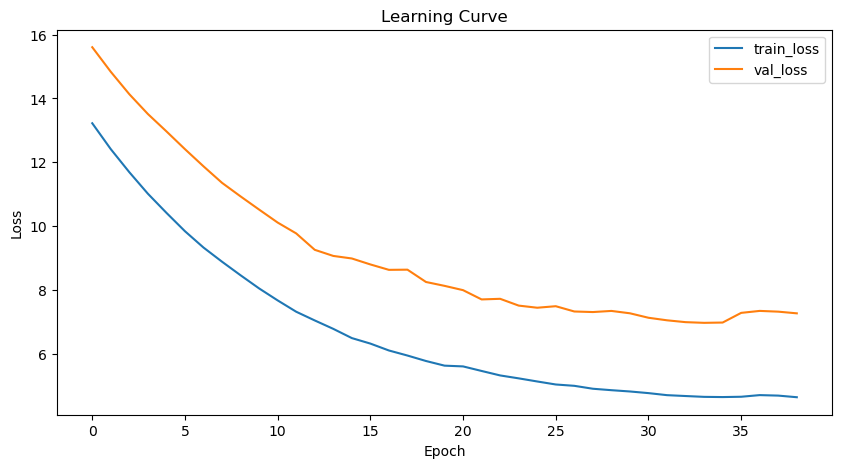

In [16]:
# fit model
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

history=None
history = model.fit(X, train_y, epochs=50, validation_data=(T, test_y), verbose=0,callbacks=[early_stop])
# demonstrate prediction
y_pred0 = model.predict(T)
plot_learning_curve(history)

In [17]:
evaluate(test_y,y_pred0, T)

'MAE: 1.8060, MSE: 6.8902, RMSE: 2.6249, MAPE: 409.5010, R2: 0.0623'

In [18]:
#将预测residual value 与 y_hat 相加
y_result = np.squeeze(y_pred0) + np.squeeze(Predictions[-y_pred0.shape[0]:])

last = TestData[-y_pred0.shape[0]:]
y_result.shape


(34,)

Test Mean Squared Error (smaller the better fit): 6.982


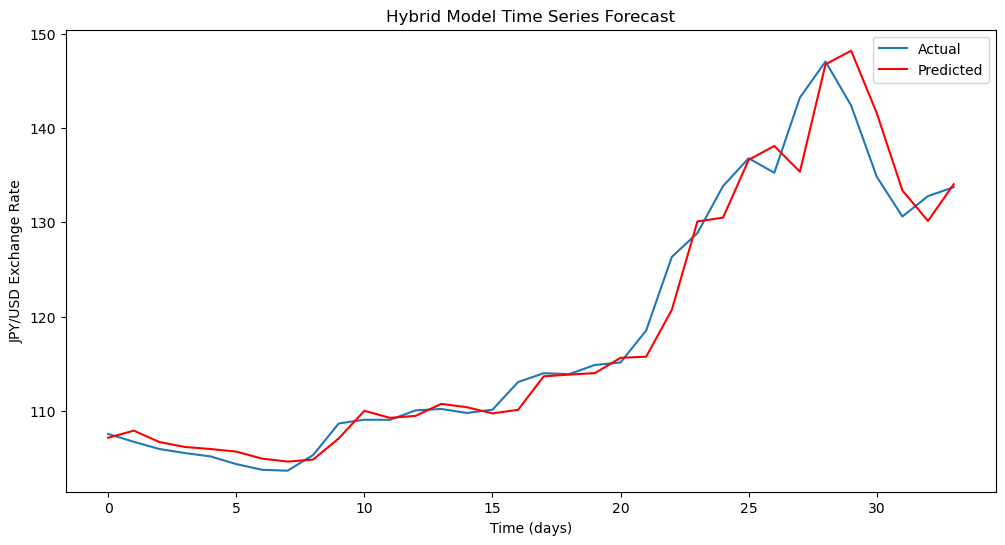

In [19]:
#Print MSE to see how good the model is
Error = mean_squared_error(TestData[-y_pred0.shape[0]:], y_result)
print('Test Mean Squared Error (smaller the better fit): %.3f' % Error)

# Create plot with labels and legend
plt.figure(figsize=(12,6))
plt.plot(TestData[-y_pred0.shape[0]:], label='Actual')
plt.plot(y_result, color='red', label='Predicted')
plt.title('Hybrid Model Time Series Forecast')
plt.xlabel('Time (days)')
plt.ylabel('JPY/USD Exchange Rate')
plt.legend()

plt.show()

In [20]:
# y_true为真实值，y_pred为预测值
mae = mean_absolute_error(last, y_result)
mse = mean_squared_error(last, y_result)
rmse = np.sqrt(mse)

pred_flat = y_result
true_flat = last

mape = np.mean(np.abs((last - y_result) / last)) * 100

r2 = r2_score(last, y_result)

print('mae:'+str(mae),'mse:'+str(mse),'rmse:'+str(rmse), 'mape:', mape, 'r2',r2)

mae:1.753339174219173 mse:6.982398393692675 rmse:2.642422826440287 mape: 1.3951962711330934 r2 0.9609710010439816


In [21]:
'''与Random Walk 比较'''
from DMtest import dm_test
test_y = last.flatten()
t_real_raw = test_y.tolist()
y = t_real_raw[1:]
rd_y=t_real_raw[0:-1]
y_pred_h = np.array(y_result).flatten()
y_pred_h = y_pred_h[1:].tolist()

rt = dm_test(y,y_pred_h,rd_y,h = 1, crit="poly", power=2)
print(rt)

dm_return(DM=-2.0855182802923427, p_value=0.04508154258515658)
